In [0]:
import pandas as pd
import pandasql as psql

In [0]:
user_usage = pd.read_csv("user_usage.csv")
user_device = pd.read_csv("user_device.csv")
devices = pd.read_csv("android_devices.csv")
devices.rename(columns={"Retail Branding": "manufacturer"}, inplace=True)

In [0]:
user_usage.head()

,outgoing_mins_per_month,outgoing_sms_per_month,monthly_mb,use_id
0,21.97,4.82,1557.33,22787
1,1710.08,136.88,7267.55,22788
2,1710.08,136.88,7267.55,22789
3,94.46,35.17,519.12,22790
4,71.59,79.26,1557.33,22792


In [0]:
user_device.head()

,use_id,user_id,platform,platform_version,device,use_type_id
0,22782,26980,ios,10.2,"iPhone7,2",2
1,22783,29628,android,6.0,Nexus 5,3
2,22784,28473,android,5.1,SM-G903F,1
3,22785,15200,ios,10.2,"iPhone7,2",3
4,22786,28239,android,6.0,ONE E1003,1


In [0]:
devices.head()

,manufacturer,Marketing Name,Device,Model
0,NaN,NaN,AD681H,Smartfren Andromax AD681H
1,NaN,NaN,FJL21,FJL21
2,NaN,NaN,T31,Panasonic T31
3,NaN,NaN,hws7721g,MediaPad 7 Youth 2
4,3Q,OC1020A,OC1020A,OC1020A


In [0]:
devices.rename(columns={"Retail Branding": "manufacturer"},inplace=True)

In [0]:
def pd_merge(user_usage):
  result= pd.merge(user_usage , user_device[['use_id' , 'platform' , 'device']] , how='inner' , on='use_id')
  return pd.merge(result, 
                  devices[['manufacturer', 'Model']],
                  left_on='device',
                  right_on='Model',
                  how='inner')

In [0]:
result=pd_merge(user_usage)
result.head()

,outgoing_mins_per_month,outgoing_sms_per_month,monthly_mb,use_id,platform,device,manufacturer,Model
0,21.97,4.82,1557.33,22787,android,GT-I9505,Samsung,GT-I9505
1,69.80,14.70,25955.55,22801,android,GT-I9505,Samsung,GT-I9505
2,249.26,253.22,1557.33,22875,android,GT-I9505,Samsung,GT-I9505
3,249.26,253.22,1557.33,22876,android,GT-I9505,Samsung,GT-I9505
4,83.46,114.06,3114.67,22880,android,GT-I9505,Samsung,GT-I9505


In [0]:
def pd_agg():
  return result.groupby("manufacturer").agg({
    "outgoing_mins_per_month":"mean",
    "outgoing_sms_per_month": "mean",
        "monthly_mb": "mean",
        "use_id": "count"})

In [0]:
pd_agg()

,outgoing_mins_per_month,outgoing_sms_per_month,monthly_mb,use_id
manufacturer,,,,
HTC,299.842955,93.059318,5144.077955,44
Huawei,81.526667,9.500000,1561.226667,3
LGE,111.530000,12.760000,1557.330000,2
Lava,60.650000,261.900000,12458.670000,2
Lenovo,215.920000,12.930000,1557.330000,2
Motorola,95.127500,65.666250,3946.500000,16
OnePlus,354.855000,48.330000,6575.410000,6
Samsung,191.010093,92.390463,4017.318889,108
Sony,177.315625,40.176250,3212.000625,16


In [0]:
def pd_sql_merge(user_usage):
  temp= psql.sqldf("select i.*, e.platform, e.device from  user_usage i inner join user_device e on i.use_id = e.use_id; ")
  return psql.sqldf("select i.*, e.manufacturer, e.model from temp i inner join devices e on i.device =e.model;")

In [0]:
res=pd_sql_merge(user_usage)
pd_sql_merge(user_usage).head()

,outgoing_mins_per_month,outgoing_sms_per_month,monthly_mb,use_id,platform,device,manufacturer,Model
0,21.97,4.82,1557.33,22787,android,GT-I9505,Samsung,GT-I9505
1,1710.08,136.88,7267.55,22788,android,SM-G930F,Samsung,SM-G930F
2,1710.08,136.88,7267.55,22789,android,SM-G930F,Samsung,SM-G930F
3,94.46,35.17,519.12,22790,android,D2303,Sony,D2303
4,71.59,79.26,1557.33,22792,android,SM-G361F,Samsung,SM-G361F


In [0]:
def pd_sql_agg():
  return psql.sqldf("select manufacturer,avg(outgoing_mins_per_month), avg(outgoing_sms_per_month), avg(monthly_mb), count(use_id) from res group by manufacturer")

In [0]:
pd_sql_agg().head()

,manufacturer,avg(outgoing_mins_per_month),avg(outgoing_sms_per_month),avg(monthly_mb),count(use_id)
0,HTC,299.842955,93.059318,5144.077955,44
1,Huawei,81.526667,9.500000,1561.226667,3
2,LGE,111.530000,12.760000,1557.330000,2
3,Lava,60.650000,261.900000,12458.670000,2
4,Lenovo,215.920000,12.930000,1557.330000,2


In [0]:
import time

def count_mean_time(func, params, N =5):
    total_time = 0
    for i in range(N):
        time1 = time.time()
        tmp_df = func(params[0])
        time2 = time.time()
        total_time += (time2 - time1)
    return total_time/N

In [0]:
ex2_times = []
for count in range(50, 200, 10):
    pandasql_time = count_mean_time(pd_sql_merge, [user_usage[:count]])
    pandas_time = count_mean_time(pd_merge, [user_usage[:count]])
    ex2_times.append({'count': count, 'pandasql_time': pandasql_time, 'pandas_time': pandas_time})

In [0]:
ex2_times_df = pd.DataFrame(ex2_times)

In [0]:
ex2_times_df.columns = ['number of rows in user_usage', 'pandas time', 'pandasql time']
ex2_times_df = ex2_times_df.set_index('number of rows in user_usage')

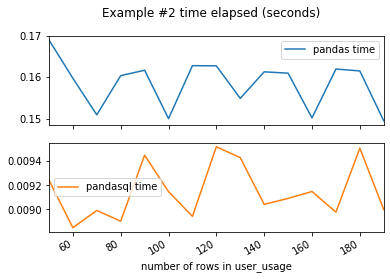

In [0]:
ax = ex2_times_df.plot(title = 'Example #2 time elapsed (seconds)', subplots = True)